In [0]:
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'./Handwritten-RNNs')
from utils import *
from utils.other_utils import *
from models.autogen import AutoGen
from models import dummy
import math
import copy
import itertools

In [0]:
Path.ls = lambda x : list(x.iterdir())

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
project_path = Path('./Handwritten-RNNs')
data_path = project_path/'data'

In [0]:
strokes = np.load(data_path/'strokes-py3.npy', allow_pickle=True)
with open(data_path/'sentences.txt') as f:
    texts = f.readlines()

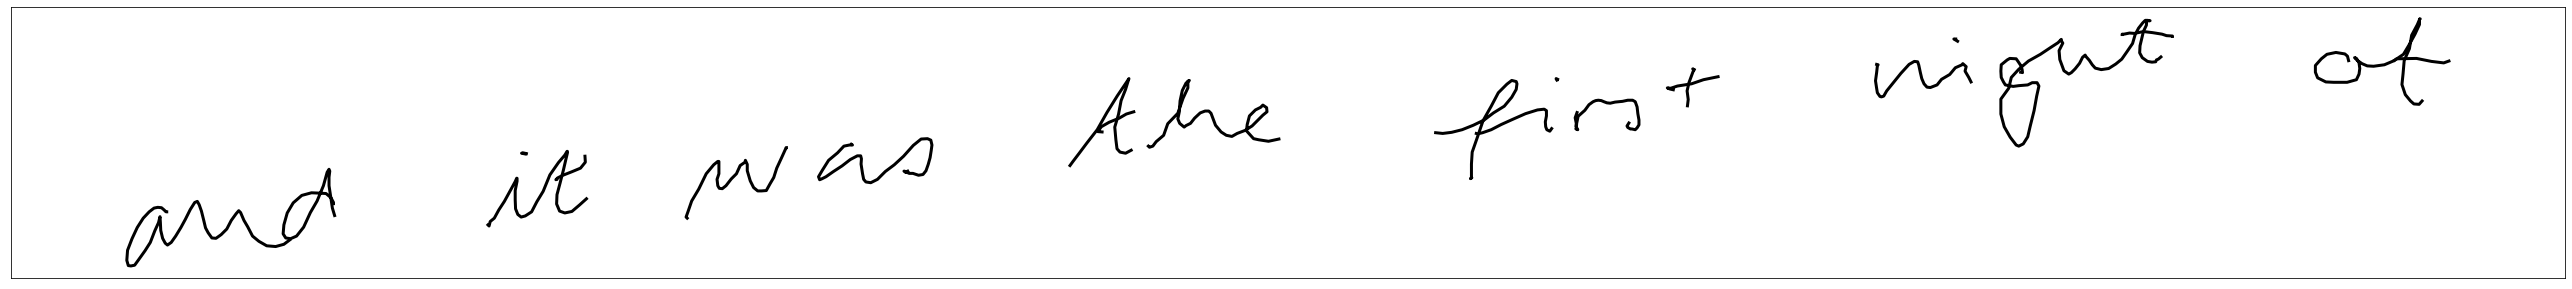

TEXT: and it was the first night of



In [8]:
idx = 99
stroke = strokes[idx]
text = texts[idx]
plot_stroke(stroke)
print('TEXT:', text)

In [0]:
maxs =[]
mins = []
for s in strokes:
    maxs.append(np.max(s,0))
    mins.append(np.min(s,0))
np.array(maxs).max(axis=0), np.array(mins).min(axis=0)

(array([ 1.  , 96.15, 56.25], dtype=float32),
 array([  0.      , -49.850002, -49.100002], dtype=float32))

In [0]:
lengths = [s.shape[0] for s in strokes]

(array([ 270.,  681., 1146., 1317., 1054.,  721.,  429.,  231.,  107.,
          44.]),
 array([ 301.,  390.,  479.,  568.,  657.,  746.,  835.,  924., 1013.,
        1102., 1191.]),
 <a list of 10 Patch objects>)

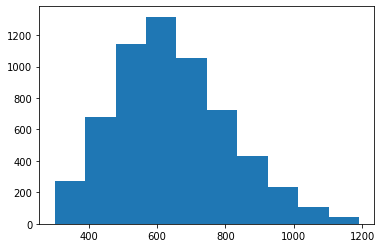

In [0]:
plt.hist(lengths,bins=10)

Start token: 2,0,0  
Stop token: 3,0,0  
Pad token: 4,0,0  
We will mask the pad tokens later in the loss function calculation.

In [0]:
process_strokes = ProcessStrokes()
norm_strokes = process_strokes.normalize(copy.deepcopy(strokes))
final_strokes =  process_strokes.add_tokens(copy.deepcopy(norm_strokes))

In [0]:
idx = 8
one_batch = collect_one_batch(copy.deepcopy(final_strokes[:10]),batch_loader)
one_stroke = process_strokes.denormalize(one_batch[idx])

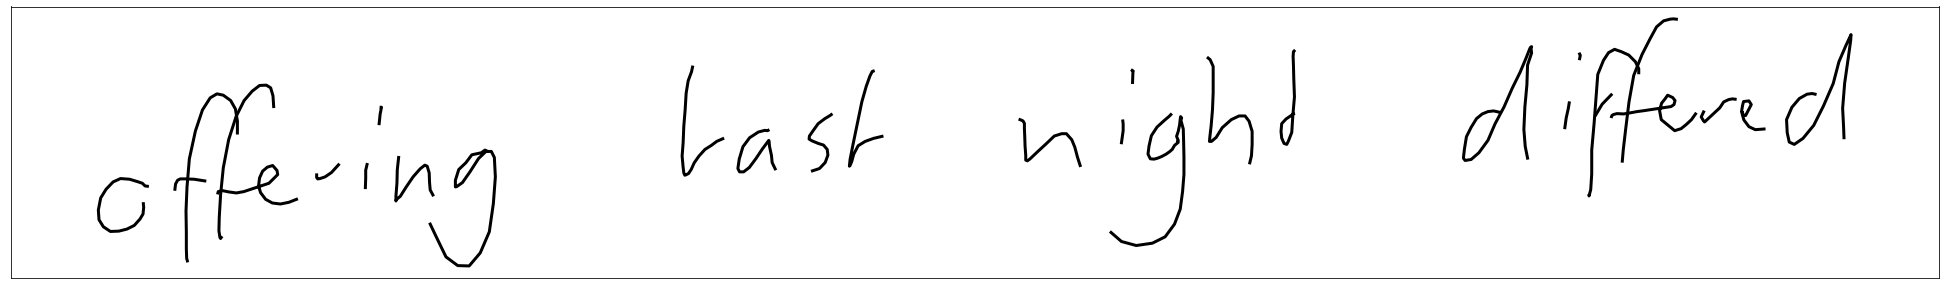

In [0]:
plot_stroke(strokes[idx])

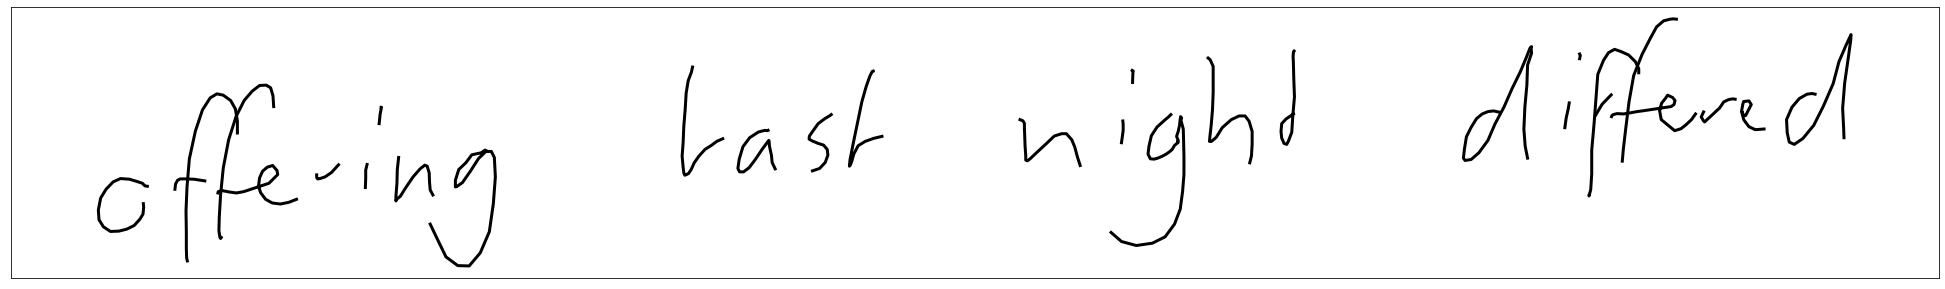

In [0]:
plot_stroke(one_stroke)

In [0]:
# If GPU available
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using the GPU


In [0]:
def mask_loss_func(preds, y_true):

    intrp,coords = y_true[:,:,0].long(), y_true[:,:,1:]
    mask = (~((intrp==2)|(intrp==3)|(intrp==4))).float()
    ce_preds,pi = preds[:2]
    ce_preds = ce_preds.transpose(-1,1)
    ce = loss_ce(ce_preds, intrp)
    ce = mask*ce

    probs = pi * calc_prob(coords,*preds[2:]) 
    probs = torch.sum(probs,-1)
    nll = -mask*(torch.log(probs+ 1e-10))
    if torch.isnan(nll.sum()):
        pdb.set_trace()
    return (ce.sum()+ nll.sum()) /mask.sum()

In [0]:
cutoff = round(0.1*len(final_strokes))
cutoff

600

In [0]:
train_loader = lambda: batch_loader(final_strokes[cutoff:],batch_sz=256,bptt=400)
valid_loader = lambda: batch_loader(final_strokes[:cutoff],batch_sz=400,bptt=400)

In [0]:
train_metric = LossMetric()
valid_metric = LossMetric()

In [0]:
def repackage_hidden(is_set,new_state):
    if is_set: 
         return model.init_hidden()
    elif isinstance(new_state,torch.Tensor): 
        return new_state.detach()
    else: 
        return tuple(repackage_hidden(False,h) for h in new_state)

In [0]:
loss_ce = nn.CrossEntropyLoss(reduction='none')

In [0]:
def train_epoch(model,train_loader,opt,clip_norm):
    model.train()
    train_metric.reset_state()
    new_state = None
    for is_set,x,y in train_loader():
        x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
        prev_state = repackage_hidden(is_set, new_state)
        params,new_state = model(x, prev_state)
        loss = mask_loss_func(params,y)
        train_metric.update_state(params,y)
        model.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.recurlayer.parameters(),clip_norm)
        opt.step()

In [0]:
def valid_epoch(model,valid_loader):
    model.eval()
    valid_metric.reset_state()
    new_state = None
    with torch.no_grad():
        for is_set,x,y in valid_loader():
            x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
            prev_state = repackage_hidden(is_set,new_state)
            params,new_state = model(x, prev_state)
            valid_metric.update_state(params,y)

In [0]:
def fit(model,epochs,max_lr,clip=0.4,wd=0.01):

    # separate out rnn layers,  wd = 0
    other_params = [p.parameters() for p in model.children() if p != model.recurlayer]
    opt =  torch.optim.AdamW([{'params':model.recurlayer.parameters(),'weight_decay':0},
                       {'params':itertools.chain(*other_params)}],
                       lr = max_lr,weight_decay = wd, betas= [0.95,0.999])
    lr = list(np.linspace(1e-6,max_lr,epochs//2)) + list(np.linspace(max_lr,1e-6,math.ceil(epochs/2)))
    mom = list(np.linspace(0.95,0.85,epochs//2)) + list(np.linspace(0.85,0.95,math.ceil(epochs/2)))
    train_logs = {'ce_tl':[],'nll_tl':[],'tot_tl':[],'ce_vl':[],'nll_vl':[],'tot_vl':[],}
    best_valid_loss = float('inf')
    for e in tqdm(range(epochs)):
        opt.defaults['lr'] = lr[e]
        opt.defaults['betas'][0] = mom[e]
        train_epoch(model,train_loader,opt,clip)
        valid_epoch(model,valid_loader)
        ce_tl,nll_tl,tot_tl = train_metric.result()
        ce_vl, nll_vl, tot_vl = valid_metric.result()

        if e%3 == 0 or e == epochs-1:
            tqdm.write(f'\nEpoch:{e}  Train Loss: {tot_tl:.4f}  Valid Loss: {tot_vl:.4f}    Best Valid:{best_valid_loss:.3f}') 

        if  tot_vl < best_valid_loss:
            best_valid_loss = tot_vl
            best_model = copy.deepcopy(model)
        
        train_logs['tot_tl'].append(tot_tl)
        train_logs['ce_tl'].append(ce_tl)
        train_logs['nll_tl'].append(nll_tl)
        train_logs['tot_vl'].append(tot_vl)
        train_logs['ce_vl'].append(ce_vl)
        train_logs['nll_vl'].append(nll_vl)

    return best_model.to(device), train_logs

In [0]:
model = AutoGen(fc_size=30, interm=4 ,rnn_layers=3, n_g=20)
model.to(device);

In [0]:
model,logs = fit(model,100,3e-3,clip=0.4,wd=0.001)

In [0]:
model,logs = fit(model,100,3e-4,clip=0.4,wd=0.001)

In [0]:
model,logs = fit(model,50,1e-4,clip=0.35,wd=0)

In [0]:
model,logs = fit(model,50,3e-5,clip=0.35,wd=0)


Epoch:0  Train Loss: -2.1014  Valid Loss: -2.0985    Best Valid:inf

Epoch:3  Train Loss: -2.1041  Valid Loss: -2.0989    Best Valid:-2.100

Epoch:6  Train Loss: -2.1047  Valid Loss: -2.0993    Best Valid:-2.100

Epoch:9  Train Loss: -2.1041  Valid Loss: -2.0990    Best Valid:-2.100

Epoch:12  Train Loss: -2.1043  Valid Loss: -2.0980    Best Valid:-2.100

Epoch:15  Train Loss: -2.1040  Valid Loss: -2.0998    Best Valid:-2.100

Epoch:18  Train Loss: -2.1050  Valid Loss: -2.1001    Best Valid:-2.100

Epoch:21  Train Loss: -2.0996  Valid Loss: -2.0994    Best Valid:-2.100

Epoch:24  Train Loss: -2.1047  Valid Loss: -2.0985    Best Valid:-2.100

Epoch:27  Train Loss: -2.1048  Valid Loss: -2.0997    Best Valid:-2.100

Epoch:30  Train Loss: -2.1045  Valid Loss: -2.0996    Best Valid:-2.100

Epoch:33  Train Loss: -2.1048  Valid Loss: -2.1000    Best Valid:-2.100

Epoch:36  Train Loss: -2.1041  Valid Loss: -2.0987    Best Valid:-2.100

Epoch:39  Train Loss: -2.1051  Valid Loss: -2.1001    Bes

In [0]:
gen_strokes = model.gen_seq(700,bias=0.15,temp=0.75)

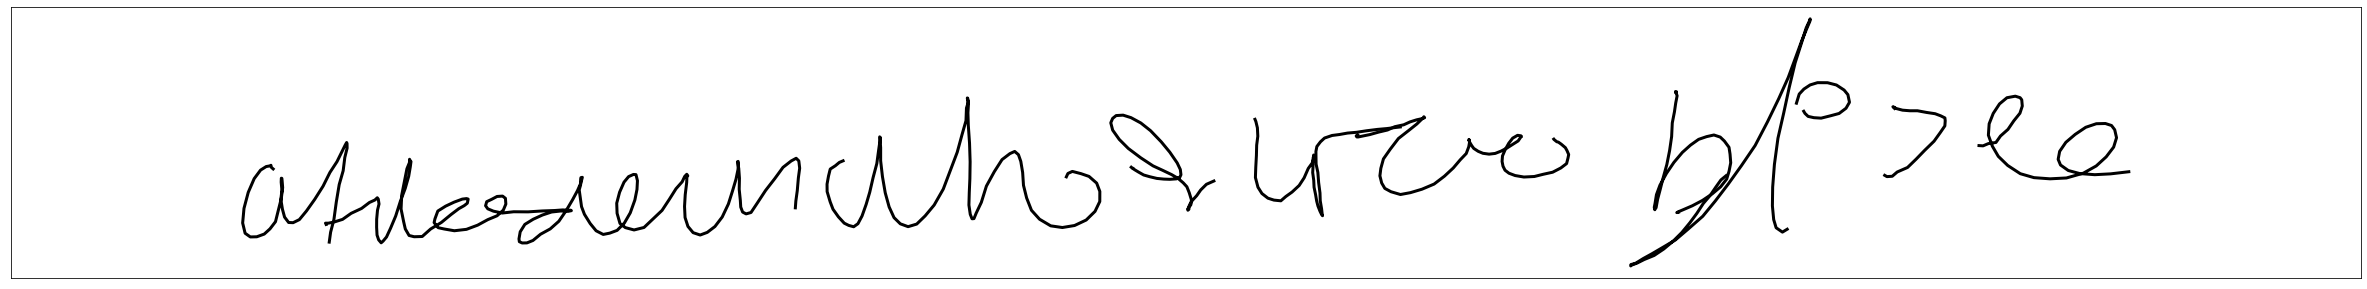

In [0]:
idx = 0
one_stroke = process_strokes.denormalize(copy.deepcopy(gen_strokes[idx]),True)
plot_stroke(one_stroke)

In [0]:
#torch.save(model.state_dict(),project_path/'unconditional.pt')

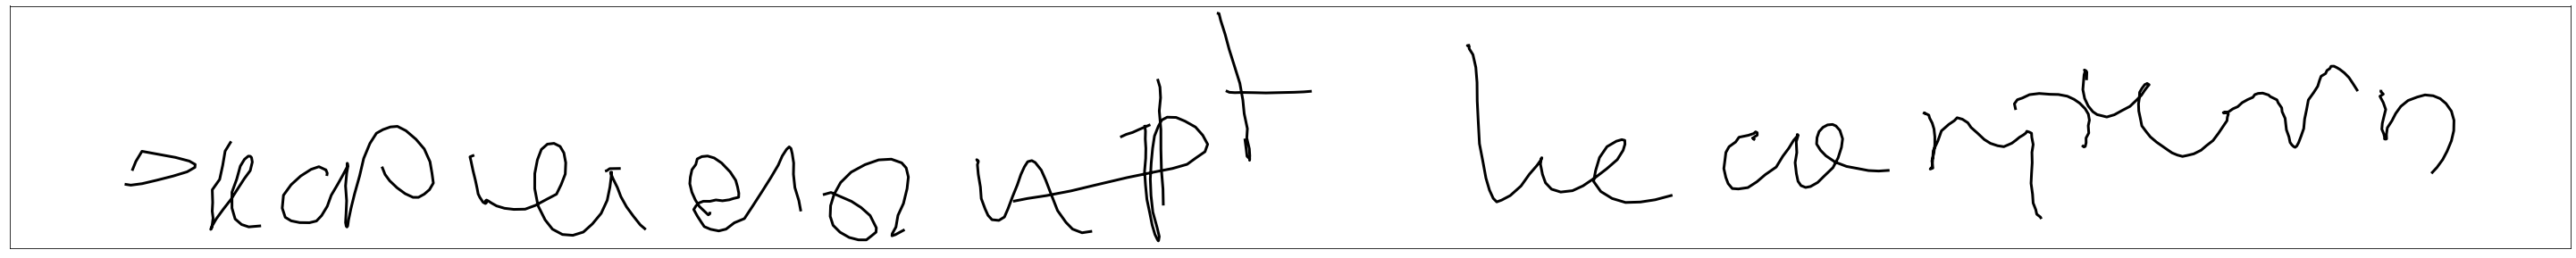

In [0]:
one_stroke = dummy.generate_unconditionally()
plot_stroke(one_stroke)